# Getting Started

Follow the general instructions from hw1_Q1

In [1]:
# get to the parent dir of mai_dul repo
import os

# os.chdir('../../')
os.getcwd()

'C:\\Users\\k67887\\PycharmProjects\\MAI_DUL_WS24\\homeworks\\hw1'

In [2]:
# run only once at the beginning of working on hw1
# !unzip -qq homeworks/hw1/data/hw1_data.zip -d homeworks/hw1/data/

# install latest version deepul package
# !pip install -e .

In [3]:
import numpy as np
from deepul.hw1_helper import (
    # Q5
    visualize_q5_data,
    q5a_save_results,
)

# Question 5: Causal Transformer: Text

Now lets consider text! You are probably already fimilar with autoregressive transformers for text, now more commonly known as Large Language Modesl (LLMs).
We will now implement a simplified version.

We will be detailing with a [small poetry dataset](https://huggingface.co/datasets/merve/poetry). See some of the data below.

In [4]:
data = visualize_q5_data()

Sample 1
The curious wits, seeing dull pensiveness
Bewray itself in my long-settl'd eyes,
Whence those same fumes of melancholy rise,
With idle pains and missing aim do guess.
Some, that know how my spring I did address,
Deem that my Muse some fruit of knowledge plies;
Others, because the prince my service tries,
Think that I think state errors to redress;
But harder judges judge ambition's ragei
Scourge of itself, still climbing slipp'ry placei
Holds my young brain captiv'd in golden cage.
O fool or over-wise! alas, the race
Of all my thoughts hath neither stop nor start
But only Stella's eyes and Stella's heart.
--------------------------------------------------------------------------------

Sample 2
My lute awake! perform the last
Labour that thou and I shall waste,
And end that I have now begun;
For when this song is sung and past,
My lute be still, for I have done.

As to be heard where ear is none,
As lead to grave in marble stone,
My song may pierce her heart as soon;
Should we

## Part (a) Modeling Text
Train a transformer on the poetry dataset.

Data Preprocessing:
* We will use a simple method to tokenize the data. We will convert each unique character into a token. (Current LLMs use more sophisticated tokenizers, most commonly, [byte-pair encoding](https://huggingface.co/learn/nlp-course/chapter6/5?fw=pt))
* Previously we have leveraged a **\<bos\>** as part of the model, just like iGPT. For text, we may not always sample a sequence that starts at the beginning. Instead, we will add the **\<bos\>** token to the beginning of every sequence in the dataset, and remove the **\<bos\>** token from the model.
* Another problem is that the model must know when to stop sampling. This is done by appending an **\<eos\>**, or end of sequence token at the end of every sequence in the dataset.
* We can now convert the sequence into subsequences of size context_length, for training!

We recommend the following hyperparameters:
* Sequence length: 128
* 5 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. Provide **5 unconditional samples** of **128 characters** showcasing the model text generation capabilities (text samples should stop after **\<eos\>**. Text after **\<eos\>** can be removed in post processing)

In [5]:

from models.GATModel import GATModel
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import math
import torch


def create_non_overlapping_windows(tokens, context_size, padding):
    tokens_tensor = torch.tensor(tokens)
    padded_length = context_size * math.ceil(len(tokens) / context_size)
    return torch.cat((tokens_tensor, torch.full((padded_length - len(tokens),), padding)), dim=0).unflatten(0, (
    context_size, padded_length // context_size))


def q5_a(train_text, test_text):
    """
    train_text: list[str] Train text sequences.
    test_text: list[str] Test text sequences.

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a list of 5 (str), 5 generated samples from the model.
    """
    batch_size = 128

    learning_rate = 0.001
    max_epochs = 100
    context_length = 128
    sliding_window_step = batch_size

    vocabulary = ["<bos>", *list(set("".join(train_text + test_text))), "<eos>"]
    vocab_to_index = {value: index for index, value in enumerate(vocabulary)}

    x_train = [item for text in train_text for item in [0, *[vocab_to_index[c] for c in text], len(vocabulary) - 1]]
    x_test = [item for text in test_text for item in [0, *[vocab_to_index[c] for c in text], len(vocabulary) - 1]]
    x_train = torch.tensor(x_train).unfold(0, context_length, sliding_window_step)
    x_test = torch.tensor(x_test).unfold(0, context_length, sliding_window_step)

    train_dataset = TensorDataset(x_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(x_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = GATModel(vocab_size=len(vocabulary), context_length=context_length, embed_dim=128)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    test_losses = []
    for epoch in range(max_epochs):
        batches = iter(train_loader)

        batch_train_loss = np.empty(len(batches))
        for i, [batch_x] in (enumerate(batches)):
            batch_x = batch_x.to(device)
            logits = model.forward(batch_x)

            loss = model.loss_function(logits, batch_x)
            batch_train_loss[i] = loss

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        train_losses.append(batch_train_loss.mean().item())

        model.eval()
        with torch.no_grad():
            batch_test_loss = np.empty(len(batches))
            for i, [test_batch_x] in enumerate(test_loader):
                test_batch_x = test_batch_x.to(device)
                test_logits = model.forward(test_batch_x)
                test_loss = model.loss_function(test_logits, test_batch_x)
                batch_test_loss[i] = test_loss.item()
            test_losses.append(batch_test_loss.mean())
        model.train()
        print(f"epoch {epoch + 1}/{max_epochs}, train loss: {train_losses[-1]}, test loss: {test_losses[-1]}")
    samples = model.generate(5, max_sequence_length=128, device=device).numpy(force=True)
    text_samples = []
    for sample in samples:
        gen_text = []
        for vi in sample:
            gen_text.append(vocabulary[vi])
            if vi == len(vocabulary) - 1:
                break
        text_samples.append("".join(gen_text))
    return train_losses, test_losses, text_samples



### Results

Once you've implemented `q5_a`, execute the cells below to visualize and save your results



epoch 1/100, train loss: 3.267783076422555, test loss: 0.07634439468383789
epoch 2/100, train loss: 2.57331497328622, test loss: 3.2117203644343784
epoch 3/100, train loss: 2.4889098167419434, test loss: 2.568599224090576
epoch 4/100, train loss: 2.4533720629555837, test loss: 2.4869632516588482
epoch 5/100, train loss: 2.425973919459752, test loss: 2.452485145841326
epoch 6/100, train loss: 2.3991493565695627, test loss: 2.4246452059064594
epoch 7/100, train loss: 2.3744169984545027, test loss: 2.398958785193307
epoch 8/100, train loss: 2.332626070295061, test loss: 2.373389707292829
epoch 9/100, train loss: 2.2837349687303816, test loss: 2.3314961910247805
epoch 10/100, train loss: 2.235805981499808, test loss: 2.2830376488821846
epoch 11/100, train loss: 2.1854686192103796, test loss: 2.2350854533059255
epoch 12/100, train loss: 2.1455804824829103, test loss: 2.1853275980268205
epoch 13/100, train loss: 2.1115923200334823, test loss: 2.146059376852853
epoch 14/100, train loss: 2.083

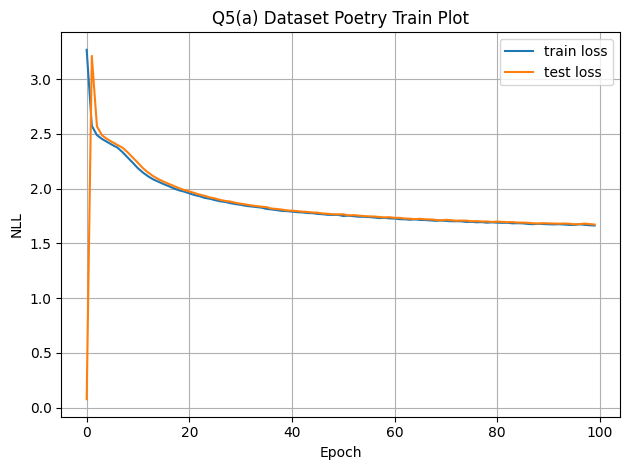

Sample 1
The P/ayce Lovel Prusave Phunce,<bos>Mose.. Collith.
When helps CUnon Anare manting. Copyrigin, Proebacing you O E
From sing from

Sample 2
"But subty barefoly to tasit;
Would you gral,
Nely am daugh, ir craces a no fitters,
With white I two, and whiled obty make,

Sample 3

I coulse kindow...

If neve be. The progaine,
The and whyly ope aver wast my shed
Bramsing ton', but that leady.

Twas 

Sample 4
I in vailet a resess:
Like clott he shey love mesteene,
To call purpleef,
The body he bring ver like

"  Whose me thy char

Sample 5
Tupend, though be lonsmey
On expread descoping smind,
With wirly spvoctort
Up thy so ther car minif
Antry brose folsetheree



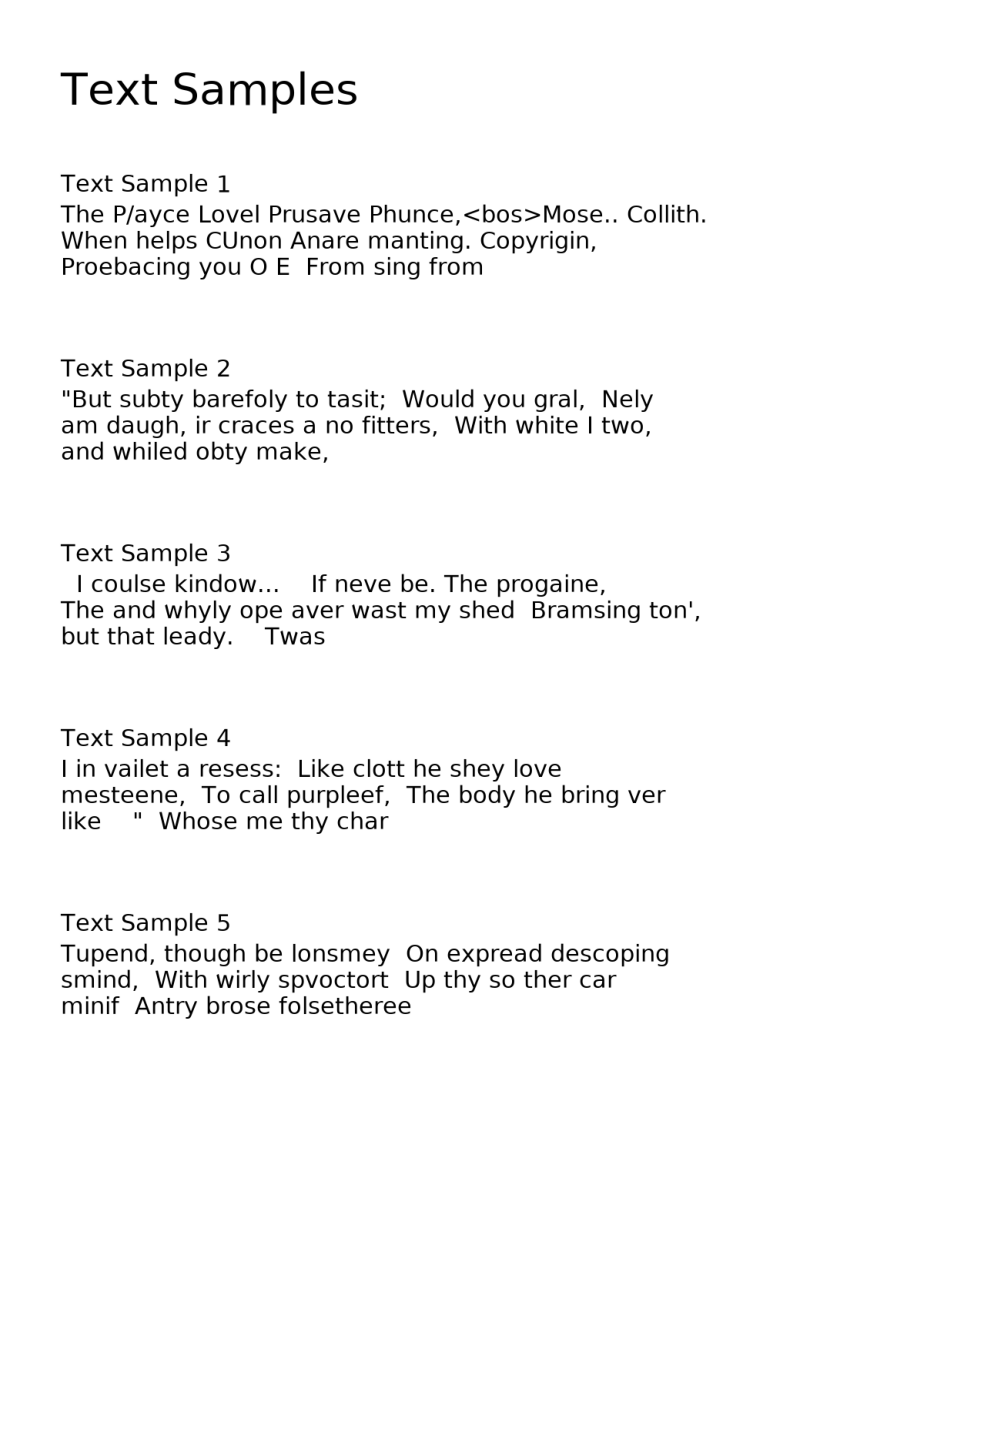

In [6]:
q5a_save_results(q5_a)